# Overview
Being able to replicate the style of artists and create something new is an interesting task. To me it speaks of a way to create inexpensive art in the style of the masters. This project specifically tries to copy the style of monet.

In this notebook we will attempt to develop an GAN to train a model to paint.

The requirements for completion of this project are listed below:

## Brief description of the problem and data

* Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
* Model Architecture
* Results and Analysis
* Conclusion
* Setup

In the following lines of code I import the packages necessary to perform the following functions:

* Data Inspection
* Data Visualization
* Model Creation
* Model Evaluation

A lot of the algorithm design was inspired by the tensor flow tutorial https://www.tensorflow.org/tutorials/generative/dcgan

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from zipfile import ZipFile
import glob
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# # Detect TPU, return appropriate distribution strategy
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy() 

# print("REPLICAS: ", strategy.num_replicas_in_sync)

## Data Import and Description
The below group of code imports the training data.

The training data is seperated into two folders from which I sample from. 

The first folder contain pictures from monet and the second contains landscape photos.

The full data set is about 7800 photos of which I sample 300 monet and 300 landscape. 

In [3]:
if os.path.exists("./training_jpg"):
    print('yes')
else:
    os.makedirs("./training_jpg")

In [4]:
j = 0

for dirname, _, filenames in os.walk('/kaggle/input/gan-getting-started/monet_jpg'):
    for filename in filenames:
        if j < 300:
            shutil.copy(os.path.join(dirname, filename), f"./training_jpg")
        j = j+1
i = 0
for dirname, _, filenames in os.walk('/kaggle/input/gan-getting-started/photo_jpg'):
    for filename in filenames:
        if i < 300:
            shutil.copy(os.path.join(dirname, filename), f"./training_jpg")
        i += 1
i = 0
for dirname, _, filenames in os.walk('./training_jpg'):
    for filename in filenames:
        i += 1
print(i)

600


In [5]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "training_jpg", label_mode=None, image_size=(64, 64), batch_size=32, shuffle=True
)
dataset = dataset.map(lambda x: x / 255.0)

Found 600 files belonging to 1 classes.


2022-10-11 16:05:26.427046: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2022-10-11 16:05:26.591883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


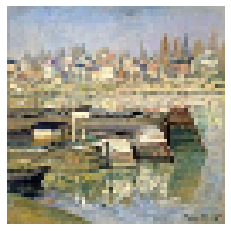

In [6]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## Model Architecture
### Model Preperation - Discrminator
The below discriminator will judge whether the generated image is real or not. The important piece here is ensuring the shape of the input matches the shape of the expected output. 

In [7]:

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

### Model Preperation - Generator

The below generator crates an image which the discriminator will judge. The important piece here is ensuring the shape of the input matches the shape of the expected output. 

In [8]:
latent_dim = 64

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              532480    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

In [9]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [10]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=64):
        self.num_img = num_img
        self.max_img = 100
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch == 4:
            for j in range(750):
                k = j*10
                for i in range(self.num_img):
                    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
                    generated_images = self.model.generator(random_latent_vectors)
                    generated_images *= 255
                    generated_images.numpy()
                    img = keras.preprocessing.image.array_to_img(generated_images[i])
                    img.save("./images/generated_img_%d.jpg" % (i+k))
        else:
            for i in range(self.num_img):
                random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
                generated_images = self.model.generator(random_latent_vectors)
                generated_images *= 255
                generated_images.numpy()
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                img.save("./generate_images_%03d/generated_img_%d.jpg" % (epoch, i))

In [11]:
epochs = 5  # In practice, use ~100 epochs
for i in range(0,epochs+1):
    if os.path.exists("./generate_images_%03d"% (i)):
        continue
    else:
        os.makedirs("./generate_images_%03d"% (i))
        
if os.path.exists("./images"):
    print('yes')
else:
    os.makedirs("./images")

## Model Application
The application of the models are done on a tape loop. Images are generated judged and weights are updated depending on the judgement.

The model creates 10 images up until the last epoch where it generates 7500 for submission. 

In [ ]:
latent_dim = 64

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


Epoch 1/5
19/19 [==============================] - 171s 9s/step - d_loss: 0.6484 - g_loss: 0.8415
Epoch 2/5
19/19 [==============================] - 168s 9s/step - d_loss: 0.5226 - g_loss: 0.9180
Epoch 3/5
19/19 [==============================] - 170s 9s/step - d_loss: 0.5241 - g_loss: 1.1315
Epoch 4/5
19/19 [==============================] - 167s 9s/step - d_loss: 0.8787 - g_loss: 0.8593
Epoch 5/5
19/19 [==============================] - 169s 9s/step - d_loss: 0.3807 - g_loss: 1.9611


In [ ]:
shutil.make_archive('images', 'zip', './images')

In [ ]:
files = glob.glob('training_jpg/*')
for f in files:
    os.remove(f)

## Conclusion
This task is extremely compute intensive. I unfortunately ran out of GPU time before submission and was only able to run on CPU. I attempted to use a google environment by the submission does not allow files and only notebooks.

I was able to get good looking pictures at around 400 to 500 epochs however without a GPU this was impossible to recreate and submit especially when creating larger files.

I would like to explore this task with more resources. I think that the mixture of input files to the model are the key to generating realistic outputs. A more curated selection will provide improved results. 